In [2]:
"""
Necessary modules
"""
import sys, os
%load_ext autoreload
%autoreload 2 # autoreload to debug/modify modules
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
from graphs.my_graph import * # my custom module for ~nice plots
# all figures will be saved to svg on the desktop for inclusions in multipanels
desktop = os.path.join(os.path.join(os.path.expanduser('~')), 'Desktop')+os.path.sep
home = os.path.join(os.path.expanduser('~'), os.path.sep)

Blue, Orange, Green, Red, Purple, Brown, Pink, Grey,\
    Kaki, Cyan = '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',\
    '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'
Inter = get_linear_colormap(Blue, Orange)(.5) # for the intermediate regime

class Namespace:
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)

from sparse_vs_balanced.exp_data import *

args = Namespace(percentile_for_freq_threshold=.9,
                 subsampling_period=10e-3,
                 window_freq=500e-3,
                 window=300e-3,
                 smoothing_for_freq=100e-3,
                 LFP_band=[0.1, 300.],
                 MUA_band=[300., 3000.],
                 MUA_smoothing=20e-3,
                 sliding=50e-3,
                 dataset='Wild_Type', debug=True)        

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
from data_analysis.IO.load_data import load_file
data = load_file('sparse_vs_balanced/data/Wild_Type/Cell14/17o27001.abf')
t, Vm, Extra = data[0], data[1][1], data[1][0]
MUA = gaussian_smoothing(\
        np.abs(butter_bandpass_filter(Extra,
                                      args.MUA_band[0], args.MUA_band[1], 1./(t[1]-t[0]), order=5)),\
                                        int(args.MUA_smoothing/(t[1]-t[0])))
LFP = butter_bandpass_filter(Extra,\
                             args.LFP_band[0], args.LFP_band[1], 1./(t[1]-t[0]), order=1)


In [67]:
cond = (t>100) & (t<200)
data = {'t':t[cond]-t[cond][0], 'Vm':Vm[cond], 'MUA':MUA[cond], 'LFP':LFP[cond]}
data['sbsmpl_t'] = data['t'][::int(5e-4/(t[1]-t[0]))]
data['sbsmpl_Vm'] = data['Vm'][::int(5e-4/(t[1]-t[0]))]
get_low_freq_power(data,
                   freq_window=args.window_freq, shift=args.sliding,
                   Fmax=10., Fmin=2.,
                   spike_threshold=-45.,
                   smoothing_for_freq=args.smoothing_for_freq,
                   debug=True)

In [ ]:
data = load_file('sparse_vs_balanced/data/Wild_Type/Cell14/17o27001.abf')


In [45]:
print()

5.54282817125


(<matplotlib.figure.Figure at 0x1c19929c88>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1c19929048>)

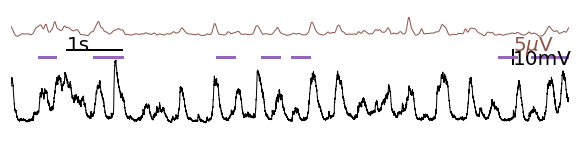

In [94]:
def show_vm_and_MUA(data, args, t0, width,
                    figsize=(10,3),
                    Vm_bar = 10, MUA_bar=0.005, T_bar=1.,
                    MUA_loc=-45,
                    vm_color='k', MUA_color='C5', spikes=-40):
    cond = (data['t']>t0) & (data['t']<t0+width)
    fig = plt.figure(figsize=figsize)
    ax = plt.subplot2grid((4, 1), (0, 0), rowspan=3)
    ax.plot(data['t'][cond], data['MUA'][cond].mean()+data['MUA'][cond]/MUA_bar*Vm_bar+MUA_loc,\
            '-', lw=1, color=MUA_color)
    cond = cond & (data['Vm']<spikes)
    ax.plot(data['t'][cond], data['Vm'][cond], '-', color=vm_color, lw=1)
    ax.plot([data['t'][cond][0]+T_bar, data['t'][cond][0]+2.*T_bar], [MUA_loc, MUA_loc], 'k-', lw=2)
    ax.plot([data['t'][cond][-1]-T_bar, data['t'][cond][-1]-T_bar], [MUA_loc, MUA_loc-Vm_bar], 'k-', lw=2)
    if T_bar>=1:
        ax.annotate(str(int(T_bar))+'s', (data['t'][cond][0]+T_bar, MUA_loc), fontsize=20)
    else:
        ax.annotate(str(int(1e3*T_bar))+'ms', (data['t'][cond][0]+T_bar, MUA_loc), fontsize=20)
    ax.annotate(str(int(Vm_bar))+'mV', (data['t'][cond][-1]-T_bar, MUA_loc-Vm_bar), fontsize=20)
    ax.annotate(str(int(1e3*MUA_bar))+'$\mu$V', (data['t'][cond][-1]-T_bar, MUA_loc), fontsize=20, color=MUA_color)
    set_plot(ax, [], xlim=[data['t'][cond][0], data['t'][cond][-1]], xticks=[], yticks=[])
    # adding the rhythmic label on top
    threshold = 5.#get_freq_threshold(args)
    cond = (data['t_low_freq']>t0) & (data['t_low_freq']<t0+width)
    for tt in data['t_low_freq'][cond]:
        i0 = np.argwhere(data['t_low_freq'][cond]==tt)
        if data['power_low_freq'][cond][i0]>=threshold:
            # ax.fill_between([tt-args.window_freq/2,tt+args.window_freq/2],
            #                 -70*np.ones(2), -50*np.ones(2), color='C4', alpha=.3, lw=0)
            ax.plot([tt-args.window/2,tt+args.window/2], -50*np.ones(2), color='C4', lw=3)
        
    return fig, ax

show_vm_and_MUA(data, args, 0, 10)

In [72]:
print(data['t'][-1])

99.9999


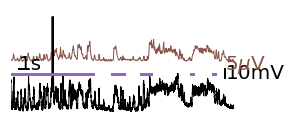

In [96]:
#fig, ax = show_vm_and_MUA(data, args, 52.5, 27, spikes=20, figsize=(4,2.7))
fig, ax = show_vm_and_MUA(data, args, 53.5, 26, spikes=20, figsize=(4,2.7))
fig.savefig(desktop+'fig.svg')

In [7]:
from sparse_vs_balanced.exp_data import load_data, get_freq_threshold
data = load_data('sparse_vs_balanced/data/Wild_Type/Cell14/17o27001.abf', args)

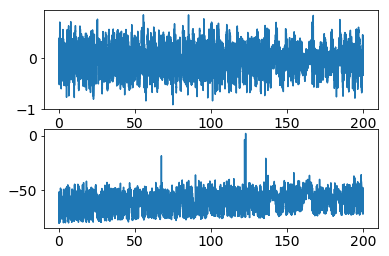

In [6]:
fig, AX = plt.subplots(2)
AX[0].plot(data['t'][::100], data['LFP'][::100])
AX[1].plot(data['t'][::100], data['Vm'][::100]);                                          

(<matplotlib.figure.Figure at 0x1c14ab0a20>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1c14a9f7b8>)

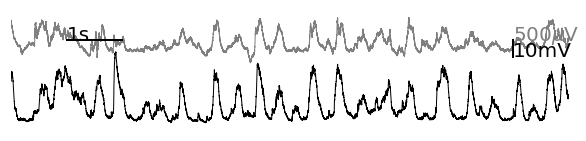

In [13]:
def show_vm_and_lfp(t, Vm, LFP, t0, width,
                    figsize=(10,3),
                    Vm_bar = 10, LFP_bar=0.5, T_bar=1.,
                    LFP_loc=-45,
                    vm_color='k', LFP_color='C7', spikes=-40):
    cond = (t>t0) & (t<t0+width)
    fig = plt.figure(figsize=figsize)
    ax = plt.subplot2grid((4, 1), (0, 0), rowspan=3)
    ax.plot(t[cond], LFP[cond].mean()-LFP[cond]/LFP_bar*Vm_bar+LFP_loc, '-', lw=1, color=LFP_color)
    cond = cond & (Vm<spikes)
    ax.plot(t[cond], Vm[cond], '-', color=vm_color, lw=1)
    ax.plot([t[cond][0]+T_bar, t[cond][0]+2.*T_bar], [LFP_loc, LFP_loc], 'k-', lw=2)
    ax.plot([t[cond][-1]-T_bar, t[cond][-1]-T_bar], [LFP_loc, LFP_loc-Vm_bar], 'k-', lw=2)
    if T_bar>=1:
        ax.annotate(str(int(T_bar))+'s', (t[cond][0]+T_bar, LFP_loc), fontsize=20)
    else:
        ax.annotate(str(int(1e3*T_bar))+'ms', (t[cond][0]+T_bar, LFP_loc), fontsize=20)
    ax.annotate(str(int(Vm_bar))+'mV', (t[cond][-1]-T_bar, LFP_loc-Vm_bar), fontsize=20)
    ax.annotate(str(int(1e3*LFP_bar))+'$\mu$V', (t[cond][-1]-T_bar, LFP_loc), fontsize=20, color=LFP_color)
    set_plot(ax, [], xlim=[t[cond][0], t[cond][-1]], xticks=[], yticks=[])
    return fig, ax

show_vm_and_lfp(t, Vm, LFP, 100, 10)

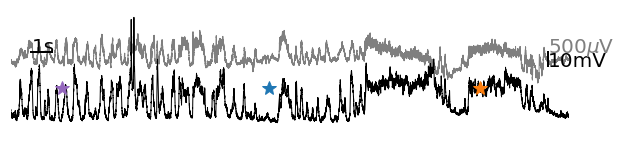

In [10]:
fig, ax = show_vm_and_lfp(t, Vm, LFP, 152.5, 27, spikes=-20, LFP_loc=-45, Vm_bar=10)
for tt, c in zip([165, 155, 175.2], ['C0', 'C4', 'C1']): ax.plot([tt], [-70], '*', color=c, ms=14)
fig.savefig(desktop+'fig.svg')

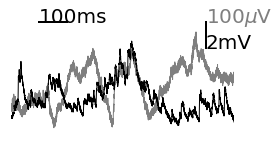

In [40]:
fig, ax = show_vm_and_lfp(t, Vm, LFP, 164.5, .8,
                      spikes=-45, LFP_loc=-86,
                      figsize=(4,3), T_bar=0.1, LFP_bar=.1, Vm_bar=2)
fig.savefig(desktop+'fig.svg')

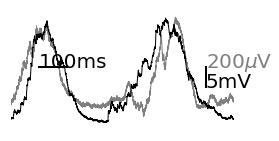

In [11]:
fig, _ = show_vm_and_lfp(t, Vm, LFP, 154.6, .8,
                      spikes=-45, LFP_loc=-80,
                      figsize=(4,3), T_bar=0.1, LFP_bar=0.2, Vm_bar=5)
fig.savefig(desktop+'fig.svg')

In [279]:
fig, _ = show_vm_and_lfp(t, Vm, LFP, 174.8, .8, 
                      spikes=-45, LFP_loc=-73,
                         figsize=(4,3), T_bar=0.1, LFP_bar=.1, Vm_bar=2)
fig.savefig(desktop+'fig.svg')

In [22]:

def get_cross_correl_coeff(data,
                           window=0.3, freq_window=0.3, shift=.05,
                           spike_threshold=-40.,
                           debug=True):
        
    if debug:
        t_key, Vm_key, LFP_key = 'sbsmpl_t', 'sbsmpl_Vm', 'sbsmpl_LFP'
    else:
        t_key, Vm_key, LFP_key = 't', 'Vm', 'LFP'
        
    t, Vm, LFP = data[t_key].copy(), data[Vm_key].copy(), data[LFP_key].copy()
    
    # removing spikes
    Vm[Vm>=spike_threshold] = spike_threshold
    
    CC = []
    
    middle = freq_window/2.
    while middle<t[-1]-freq_window/2.:
        cond = (t>middle-window/2.) & (t<middle+window/2.)
        CC.append(np.corrcoef(Vm[cond], -LFP[cond])[0,1])
        middle+=shift
        
    data['CC_Vm_LFP'] = np.array(CC)
        
def analyze_full_dataset(args,
                         window=0.3, freq_window=0.5, shift=.025,
                         low_muV=-60, high_muV=-50,
                         spike_threshold=-40., debug=True):

    DATASET = get_full_dataset(args, include_only_chosen=True)
    
    ANALYZED_DATA = {'CC_Vm_LFP':[],
                     'muV':[],
                     'smooth_power_low_freq':[]}

    for d in DATASET:
        data = load_data(d['files'][0], args)
        get_cross_correl_coeff(data, freq_window=freq_window, shift=shift, window=window, debug=debug)
        ANALYZED_DATA['CC_Vm_LFP'].append(data['CC_Vm_LFP'])
        ANALYZED_DATA['muV'].append(data['muV'])
        ANALYZED_DATA['smooth_power_low_freq'].append(data['smooth_power_low_freq'])
    return ANALYZED_DATA

In [16]:
from sparse_vs_balanced.exp_data import load_data, get_freq_threshold
data = load_data('sparse_vs_balanced/data/Wild_Type/Cell14/17o27001.abf', args)
get_cross_correl_coeff(data, freq_window=0.5, shift=0.025, window=0.3, debug=True)

NameError: name 'DATASET' is not defined

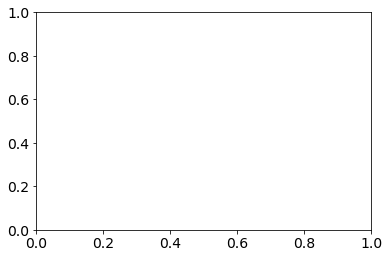

NameError: name 'DATASET' is not defined

In [24]:
from matplotlib.cm import viridis
fig, ax = plt.subplots(1)
for i, pf, cc in zip(range(len(DATASET)), ANALYZED_DATA['smooth_power_low_freq'], ANALYZED_DATA['CC_Vm_LFP']):
     ax.plot(pf, cc, 'o', color=viridis(i/len(DATASET)), ms=1)

NameError: name 'pf' is not defined

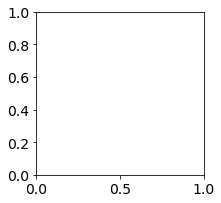

NameError: name 'pf' is not defined

In [23]:
"""
On the whole dataset
"""
fig, ax = plt.subplots(figsize=(3,3))
bounds = [-75, -65, -55, -45]
for i, cond, color, label in zip(range(4),
                               [(pf>5.5) & np.isfinite(cc),\
                                (pf<5.5) & np.isfinite(cc) & (muV>bounds[0]) & (muV<=bounds[1]),
                                (pf<5.5) & np.isfinite(cc) & (muV>bounds[1]) & (muV<=bounds[2]),
                                (pf<5.5) & np.isfinite(cc) & (muV>bounds[2]) & (muV<=bounds[3])],
                               [Purple, Blue, Inter, Orange],
                               ['most 50\% rhythmic \n(conservative for non-rhythmic)',
                                '$\mu_V \in $[-75,-65]mV',
                                '$\mu_V \in $[-65,-55]mV',
                                '$\mu_V \in $[-55,-45]mV']):
    if len(cc[cond])>1:
          ax.bar([i], [np.mean(cc[cond])], yerr=[np.std(cc[cond])], color=color, label=label)
    print(ttest_ind(cc[cond], cc[pf>5.5]))
ax.legend(frameon=False, prop={'size':'x-small'},loc=(1.,0.3))
ax.set_title('n='+str(len(ANALYZED_DATA['muV']))+'cells')
set_plot(ax, ['left'], ylabel='Cell vs -LFP Correl.', yticks=[-0.5,0,0.5,1.], xticks=[])    

In [579]:
ANALYZED_DATA = analyze_full_dataset(args)

/Users/yzerlaut/anaconda/lib/python3.5/site-packages/numpy/lib/function_base.py:3167: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/yzerlaut/anaconda/lib/python3.5/site-packages/numpy/lib/function_base.py:3168: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


In [837]:
percentiles = np.load('sparse_vs_balanced/data'+os.path.sep+'Wild_Type_freq_percentiles.npy')
freq_threshold = percentiles[int(100.*.5)] # 50%
freq_threshold_high = percentiles[int(100.*.9)] # 20%
Ncount_min = 200

fig, ax = plt.subplots(1, figsize=(3,2))
bounds = [-75, -65, -55, -45]

CC = [{'id':[],'cc':[]} for i in range(5)]
# CHECK THE CELL 1 !!
for n in np.concatenate([range(1), range(2,len(ANALYZED_DATA['muV']))]):
    cc, pf, muV = ANALYZED_DATA['CC_Vm_LFP'][n],\
                   ANALYZED_DATA['smooth_power_low_freq'][n],\
                    ANALYZED_DATA['muV'][n]
    for i, cond in zip(range(5),
                       [(pf>freq_threshold_high) & np.isfinite(cc),\
                        (pf>freq_threshold) & np.isfinite(cc),\
                        (pf<freq_threshold) & np.isfinite(cc) & (muV>bounds[0]) & (muV<=bounds[1]),
                        (pf<freq_threshold) & np.isfinite(cc) & (muV>bounds[1]) & (muV<=bounds[2]),
                        (pf<freq_threshold) & np.isfinite(cc) & (muV>bounds[2]) & (muV<=bounds[3])]):
        if len(cc[cond])>Ncount_min:
            # ax.plot([i-.15], [np.mean(cc[cond])], 'o',
            #         color=viridis(n/len(ANALYZED_DATA['muV'])))
            CC[i]['cc'].append(np.mean(cc[cond]))
            CC[i]['id'].append(n)
        ax2.semilogy([i+n*.03], [1+len(cc[cond])], 'o', color=viridis(n/len(ANALYZED_DATA['muV'])))

for i, color, hatch, label in zip(range(5),
                                        [Pink, Purple, Blue, Inter, Orange],
                                        # ['////', '', '', '', ''],
                                        ['', '', '', '', ''],
                                ['10% most rhythmic data \n(conservative rhythmic dataset)',
                                '50% most rhythmic data \n(conservative non-rhythmic dataset)',
                                '$\mu_V \in $[-75,-65]mV',
                                '$\mu_V \in $[-65,-55]mV',
                                '$\mu_V \in $[-55,-45]mV']):
    ax.bar([i], [np.mean(CC[i]['cc'])], yerr=[np.std(CC[i]['cc'])], color=color, label=label, hatch=hatch)

ax.legend(loc=(0.,1.), frameon=False)
from itertools import product
for i, j in product(range(5), range(5)):
    if j==0:
        ax.annotate('n='+str(len(CC[i]['id'])), (i-.4,0))
    if i<j:
        ax.annotate(str(1+i)+', '+str(1+j)+'-> p= %.1e' % ttest_ind(CC[i]['cc'], CC[j]['cc']).pvalue,
                    (1+3*j/5.,1-i/5.), xycoords='axes fraction')
# ax.set_title('n='+str(len(ANALYZED_DATA['muV']))+'cells')
set_plot(ax, ['left'], ylabel='Cell vs -LFP Correl.', yticks=[0,0.4,0.8], xticks=[])
fig.savefig(desktop+'temp.svg')

# Visualizing all cells 

In [849]:
data = load_data(DATASET[0]['files'][0], args)
show_vm_and_lfp(data['t'], data['Vm'], data['LFP'], 100, 10, LFP_bar=0.3)

(<matplotlib.figure.Figure at 0x1a40b768d0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a40b91780>)

In [847]:
data = load_data(DATASET[1]['files'][0], args)
show_vm_and_lfp(data['t'], data['Vm'], data['LFP'], 100, 10, LFP_bar=0.2)

(<matplotlib.figure.Figure at 0x1a446dc780>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a44908c18>)

In [850]:
data = load_data(DATASET[2]['files'][0], args)
show_vm_and_lfp(data['t'], data['Vm'], data['LFP'], 100, 10, LFP_bar=0.2)

(<matplotlib.figure.Figure at 0x1a40ba54e0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a44c93ef0>)

In [851]:
data = load_data(DATASET[3]['files'][0], args)
show_vm_and_lfp(data['t'], data['Vm'], data['LFP'], 100, 10, LFP_bar=0.2)

(<matplotlib.figure.Figure at 0x1a44ca92e8>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a4136b470>)

In [852]:
data = load_data(DATASET[4]['files'][0], args)
show_vm_and_lfp(data['t'], data['Vm'], data['LFP'], 100, 10, LFP_bar=0.2)

(<matplotlib.figure.Figure at 0x1a44641a20>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a41398d30>)

In [853]:
data = load_data(DATASET[5]['files'][0], args)
show_vm_and_lfp(data['t'], data['Vm'], data['LFP'], 100, 10, LFP_bar=0.2)

(<matplotlib.figure.Figure at 0x1a413a49b0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a45968ac8>)

In [854]:
data = load_data(DATASET[6]['files'][0], args)
show_vm_and_lfp(data['t'], data['Vm'], data['LFP'], 100, 10, LFP_bar=0.2)

(<matplotlib.figure.Figure at 0x1a443b4518>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a4a9ef828>)

In [855]:
data = load_data(DATASET[7]['files'][0], args)
show_vm_and_lfp(data['t'], data['Vm'], data['LFP'], 100, 10, LFP_bar=0.2)

(<matplotlib.figure.Figure at 0x1a4aa04dd8>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a4aa1efd0>)

In [856]:
data = load_data(DATASET[8]['files'][0], args)
show_vm_and_lfp(data['t'], data['Vm'], data['LFP'], 100, 10, LFP_bar=0.2)

(<matplotlib.figure.Figure at 0x1a43729b38>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a43745eb8>)

In [ ]:
def subplot(ax, data, muV_min=-60, muV_max=-50):
    cond = data['power_low_freq']<=get_freq_threshold(args)
    ax.bar([0], np.mean(data['CC_Vm_LFP'][~cond]), yerr=np.std(data['CC_Vm_LFP'][~cond]), color='C4')
    ax.bar([1], np.mean(data['CC_Vm_LFP'][cond & (data['muV']<muV_min)]),\
            yerr=np.std(data['CC_Vm_LFP'][cond & (data['muV']<muV_min)]))
    ax.bar([2], np.mean(data['CC_Vm_LFP'][cond & (data['muV']>muV_min)& (data['muV']<muV_max)]),
            yerr=np.std(data['CC_Vm_LFP'][cond & (data['muV']>muV_min)& (data['muV']<muV_max)]))
    ax.bar([3], np.mean(data['CC_Vm_LFP'][cond & (data['muV']>muV_max)]),
           yerr=np.std(data['CC_Vm_LFP'][cond & (data['muV']>muV_max)]))
subplot(plt.gca(), data, muV_min=-60, muV_max=-50)    

In [448]:
from sparse_vs_balanced.exp_data import get_full_dataset
DATASET = get_full_dataset(args, include_only_chosen=True)
fig, AX = plt.subplots(1, len(DATASET), figsize=(12,3))
for ax, d in zip(AX, DATASET):
    data = load_data(d['files'][0], args)
    get_cross_correl_coeff(data, freq_window=0.5, shift=.025, window=.5, debug=True)
    subplot(ax, data, muV_min=-65, muV_max=-55)
                   

/Users/yzerlaut/anaconda/lib/python3.5/site-packages/numpy/lib/function_base.py:3167: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/yzerlaut/anaconda/lib/python3.5/site-packages/numpy/lib/function_base.py:3168: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


/Users/yzerlaut/anaconda/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/yzerlaut/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/yzerlaut/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/yzerlaut/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/yzerlaut/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [447]:
np.corrcoef(data['Vm'][::100], -data['LFP'][::100])[1,0]

0.52837561679225142

In [ ]:
fig, AX = plt.subplots(3, figsize=(10,3))
AX[0].plot(data['t'][::100], data['Vm'][::100])
AX[1].plot(data['t'][::100], data['LFP'][::100])
AX[2].plot(data['t_muV'], data['CC_Vm_LFP'])

In [297]:
data.keys()

dict_keys(['tspikes', 'Iapp', 'sbsmpl_dt', 'Light_OFF_indices', 'sbsmpl_LFP', 'sbsmpl_Vm', 'ispikes', 'muV', 'sbsmpl_t', 't_muV', 'Light_ON_indices', 'filename', 'Vm', 'smooth_power_low_freq', 'LFP', 'name', 't', 'CC_Vm_LFP', 'dt', 'power_low_freq'])

In [69]:
from data_analysis.freq_analysis.fourier_for_real import time_to_freq, FT
from data_analysis.processing.signanalysis import gaussian_smoothing
def get_Vm_power(t, Vm,
                 window=1., shift=.05,
                 Fmax=10., Fmin=2., subsampling=1e-2):
    TIME, LOW_FREQS = [], []
    start=0
    isub = int(subsampling/(t[1]-t[0]))
    while start<t[-1]-window:
        cond = (t>start) & (t<start+window)
        tt = t[cond][::isub]
        freqs = time_to_freq(len(tt), tt[1]-tt[0])
        TF = FT(Vm[cond][::isub], len(tt), tt[1]-tt[0])
        start+=shift
        TIME.append(start+window/2.)
        freq_cond = (freqs>Fmin) & (freqs<Fmax)
        LOW_FREQS.append(np.array(np.abs(TF)**2)[freq_cond].max())
    return np.array(TIME), np.array(LOW_FREQS)

In [70]:
T, P = get_Vm_power(t, Vm)

In [63]:
def show_vm_and_lfp(t0, width):
    fig = plt.figure(figsize=(10,3))
    cond = (t>t0) & (t<t0+width) #& (Vm<-30)
    ax = plt.subplot2grid((4, 1), (0, 0))
    ax.plot(t[cond], LFP[cond], 'k-')
    ax.plot([t[cond][-1]-1, t[cond][-1]-1], ax.get_ylim()[0]+.5*np.arange(2), '-', lw=2, color=Grey)
    ax.annotate('500$\mu$V', (t[cond][-1]-2.1, ax.get_ylim()[0]), fontsize=20)
    set_plot(ax, [], xlim=[t[cond][0], t[cond][-1]], xticks=[], yticks=[])
    ax = plt.subplot2grid((4, 1), (2, 0), rowspan=2)
    ax.plot(t[cond], Vm[cond], 'k-')
    ax.plot([t[cond][0], t[cond][0]+1], [-35,-35], '-', lw=2, color=Grey);ax.annotate('1s', (t[cond][0]+.2, -33), fontsize=20)
    ax.plot([t[cond][-1]-1, t[cond][-1]-1], [-45,-35], '-', lw=2, color=Grey);ax.annotate('5mV', (t[cond][-1]-2.1, -40), fontsize=20)
    set_plot(ax, [], xlim=[t[cond][0], t[cond][-1]], xticks=[], yticks=[])
    ax = plt.subplot2grid((4, 1), (1, 0))
    cond = (T>t0) & (T<t0+width) #& (Vm<-30)
    ax.plot(T[cond], P[cond], 'k-')
    set_plot(ax, [], xlim=[T[cond][0], T[cond][-1]], xticks=[], yticks=[])
    return fig
fig = show_vm_and_lfp(100, 10)    

In [66]:
show_vm_and_lfp(150, 30);    

In [171]:
show_vm(200, 20)    

In [22]:
from matplotlib.cm import copper
# Chosen_Episodes = [1, 5, 9, 13, 19, 21, 30, 26, 46] 
Chosen_Episodes = [5, 9, 19, 21, 30, 46, 13, 26] 
# Chosen_Episodes = [1, 5, 9, 11, 13, 19, 21, 30, 26, 46] 
# Chosen_Episodes = [1, 5, 9, 11, 13, 19, 21, 30, 46, 26] 
BA_Episodes = [34] 
fig = make_PV_Arch_fig(Chosen_Episodes, BA_Episodes);
fig.savefig(desktop+'temp.svg')

In [21]:
def make_PV_Arch_fig(Chosen_Episodes, BA_Episodes):
    Tbar, Vshift, tzoom = 200, 0, [-.5, 1]

    fig, ax = plt.subplots(1, figsize=(5, 3))
    for i, iepisode in enumerate(Chosen_Episodes):
        t0 = t[Light_indices[iepisode]]
        cond = (t>t0+tzoom[0]) & (t<t0+tzoom[1])
        ax.plot(1e3*(t[cond]-t0), Vm[cond]+Vshift*i, color=copper(1-i/len(Chosen_Episodes)/1.5),lw=0.5)
    ax.plot(1e3*(t[cond]-t0), Vm[cond]+Vshift*i, color='k', lw=1)
    ax.plot(1e3*tzoom[0]*np.ones(2), [-45, -35], lw=3, color='gray')
    ax.annotate('10mV',(-0.1, .4), rotation=90, fontsize=14, xycoords='axes fraction')
    ax.plot([1e3*tzoom[0],1e3*tzoom[0]+Tbar], [-75, -75], lw=3, color='gray')
    ax.annotate(str(Tbar)+' ms',
                (0.1, -0.1), fontsize=14, xycoords='axes fraction')
    ax.fill_between(t[cond],
                    ax.get_ylim()[0]+0.*t[cond],
                    ax.get_ylim()[0]+Iapp[cond]*(ax.get_ylim()[1]-ax.get_ylim()[0]), color='y', alpha=.2)
    set_plot(ax, [], xticks=[], yticks=[])
    # one BA episode in inset
    ax2 = plt.axes((.7,.6, .2, .3))
    tzoom = [-1, 1]
    for i, iepisode in enumerate(BA_Episodes):
        t0 = t[Light_indices[iepisode]]
        cond = (t>t0+tzoom[0]) & (t<t0+tzoom[1])
        ax2.plot(1e3*(t[cond]-t0), Vm[cond]+Vshift*i, color=copper(i/len(BA_Episodes)/2.),lw=0.5)
    ax2.fill_between([0, 400], ax.get_ylim()[0]*np.ones(2), ax.get_ylim()[1]*np.ones(2), color='y', alpha=.2)
    set_plot(ax2, [], xticks=[], yticks=[])
    return fig

In [225]:
from data_analysis.freq_analysis.wavelet_transform import my_cwt

In [341]:
N = 4 # subsampling
sbsmpl_t, sbsmpl_Vm, sbsmpl_dt  = t[::N], Vm[::N], t[N]-t[0]
# wavelet_coeffs = my_cwt(sbsmpl_Vm, np.linspace(2, 10, 6), dt).mean(axis=0)
# wavelet_coeffs2 = my_cwt(sbsmpl_Vm, np.linspace(20, 100, 10), dt).mean(axis=0)
# wavelet_coeffs = wavelet_coeffs1/(1+wavelet_coeffs2)

In [356]:
from data_analysis.processing.filters import butter_bandpass_filter, butter_lowpass_filter

low_freqs = butter_bandpass_filter(sbsmpl_Vm,
                                   1., 10.,
                                   1./sbsmpl_dt, order=1)
t0, width = 50, 20
######### Vm
fig = plt.figure(figsize=(17,3))
cond = (sbsmpl_t>t0) & (sbsmpl_t<t0+width)
plt.plot(sbsmpl_t[cond], low_freqs[cond])

In [317]:
Twindow = 0.2
iw = int(Twindow/sbsmpl_dt)
i = 0
var_wvltcoeffs, t_var = [], []
while i<len(sbsmpl_t):
    t_var.append(sbsmpl_t[i:i+iw].mean())
    var_wvltcoeffs.append(wavelet_coeffs[i:i+iw].std())
    i+=int(iw/4)
var_wvltcoeffs = np.array(var_wvltcoeffs)

In [318]:
from data_analysis.processing.signanalysis import gaussian_smoothing
Tsmooth = 0.05
smooth_wvltcoeffs = gaussian_smoothing(np.abs(var_wvltcoeffs), int(Tsmooth/(t_var[1]-t_var[0])))

(<matplotlib.figure.Figure at 0x1c13fa32e8>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1c12da8710>)

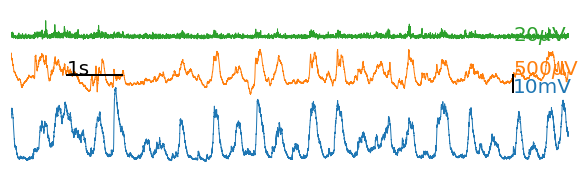

In [109]:
def show_vm_and_lfp_and_MUA(t, Vm, LFP, MUA, t0, width,
                            figsize=(10,4),
                            Vm_bar = 10, LFP_bar=0.5, MUA_bar=0.02, T_bar=1.,
                            LFP_loc=-45, MUA_loc=-25,
                            vm_color='C0', LFP_color='C1', MUA_color='C2',
                            spikes=-40):
    cond = (t>t0) & (t<t0+width)
    fig = plt.figure(figsize=figsize)
    ax = plt.subplot2grid((4, 1), (0, 0), rowspan=3)
    ax.plot(t[cond], LFP[cond].mean()-LFP[cond]/LFP_bar*Vm_bar+LFP_loc, '-', lw=1, color=LFP_color)
    ax.plot(t[cond], MUA[cond].mean()+MUA[cond]/MUA_bar*Vm_bar+MUA_loc, '-',
            lw=1, color=MUA_color)
    cond = cond & (Vm<spikes)
    ax.plot(t[cond], Vm[cond], '-', color=vm_color, lw=1)
    ax.plot([t[cond][0]+T_bar, t[cond][0]+2.*T_bar], [LFP_loc, LFP_loc], 'k-', lw=2)
    ax.plot([t[cond][-1]-T_bar, t[cond][-1]-T_bar], [LFP_loc, LFP_loc-Vm_bar], 'k-', lw=2)
    if T_bar>=1:
        ax.annotate(str(int(T_bar))+'s', (t[cond][0]+T_bar, LFP_loc), fontsize=20)
    else:
        ax.annotate(str(int(1e3*T_bar))+'ms', (t[cond][0]+T_bar, LFP_loc), fontsize=20)
    ax.annotate(str(int(Vm_bar))+'mV', (t[cond][-1]-T_bar, LFP_loc-Vm_bar), fontsize=20, color=vm_color)
    ax.annotate(str(int(1e3*LFP_bar))+'$\mu$V', (t[cond][-1]-T_bar, LFP_loc), fontsize=20, color=LFP_color)
    ax.annotate(str(int(1e3*MUA_bar))+'$\mu$V', (t[cond][-1]-T_bar, MUA_loc), fontsize=20, color=MUA_color)
    set_plot(ax, [], xlim=[t[cond][0], t[cond][-1]], xticks=[], yticks=[])
    return fig, ax

show_vm_and_lfp_and_MUA(t, Vm, LFP, MUA, 100, 10)

In [ ]:
from data_analysis.processing.signanalysis import gaussian_smoothing
from data_analysis.IO.load_data import load_file
data = load_file('sparse_vs_balanced/data/Wild_Type/Cell14/17o27001.abf')
t, Vm, Extra = data[0], data[1][1], data[1][0]
from data_analysis.processing.filters import butter_lowpass_filter, butter_bandpass_filter
MUA = gaussian_smoothing(np.abs(butter_bandpass_filter(Extra, 300., 3000., 1./(t[1]-t[0]), order=5)), 20e-3/(t[1]-t[0]))

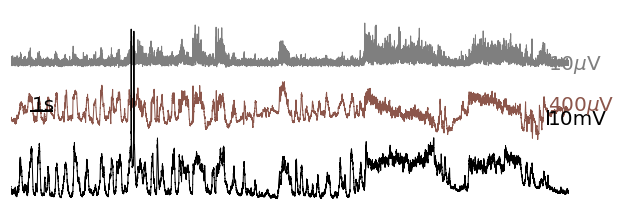

In [107]:
fig, ax = show_vm_and_lfp_and_MUA(t, Vm, LFP, MUA, 152.5, 27, spikes=30,
                                  figsize=(10,5),
                                  Vm_bar = 10, LFP_bar=0.4, MUA_bar=0.01, T_bar=1.,
                                  vm_color='k', LFP_color='C5', MUA_color='C7',
                                  LFP_loc=-30, MUA_loc=0)
#fig.savefig(desktop+'fig.svg')

In [33]:
def get_MUA_power(data,
                  window=0.3, freq_window=0.3, shift=.05,
                  debug=True):
        
    if debug:
        t_key, MUA_key = 'sbsmpl_t', 'sbsmpl_MUA'
    else:
        t_key, MUA_key = 't', 'MUA'
        
    t, MUA = data[t_key].copy(), data[MUA_key].copy()
    
    POW = []
    
    middle = freq_window/2.
    while middle<t[-1]-freq_window/2.:
        cond = (t>middle-window/2.) & (t<middle+window/2.)
        POW.append(np.mean(MUA[cond]))
        middle+=shift
    data['MUA_Pow'] = np.array(POW)

def analyze_full_dataset(args,
                         window=0.3, freq_window=0.5, shift=.025,
                         low_muV=-60, high_muV=-50,
                         spike_threshold=-40., debug=True):

    DATASET = get_full_dataset(args, include_only_chosen=True)
    
    ANALYZED_DATA = {'MUA_Pow':[],
                     'muV':[],
                     'smooth_power_low_freq':[]}

    for d in DATASET:
        data = load_data(d['files'][0], args)
        get_MUA_power(data, freq_window=freq_window, shift=shift, window=window, debug=debug)
        ANALYZED_DATA['MUA_Pow'].append(data['MUA_Pow'].flatten())
        ANALYZED_DATA['muV'].append(data['muV'])
    return ANALYZED_DATA
    

In [34]:
from sparse_vs_balanced.exp_data import get_full_dataset
DATASET = get_full_dataset(args, include_only_chosen=True)
ANALYZED_DATA = analyze_full_dataset(args)

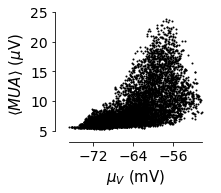

In [50]:
fig, ax = plt.subplots(1, figsize=(3.5,3))
plt.subplots_adjust(left=.3, bottom=.3)      
i=0
ax.plot(ANALYZED_DATA['muV'][i], 1e3*ANALYZED_DATA['MUA_Pow'][i], 'ko', ms=1)
set_plot(ax, xlabel='$\mu_V$ (mV)', ylabel=r'$\langle MUA \rangle$ ($\mu$V)')
fig.savefig(desktop+'fig.png')                                         

In [21]:
len(DATASET)

14

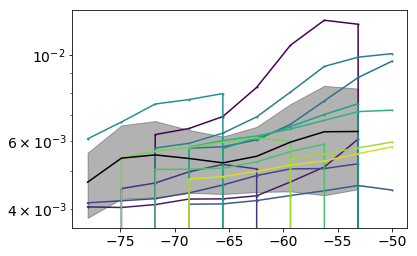

In [104]:
from matplotlib.cm import viridis
fig, ax = plt.subplots(1)
MUV = np.linspace(-78, -50, 10)
ANALYZED_DATA['COUNTER'], ANALYZED_DATA['MUA'] = [], []
                                         
for i, pf, cc in zip(range(len(DATASET)), ANALYZED_DATA['muV'], ANALYZED_DATA['MUA_Pow']):
    H = np.digitize(pf, bins=MUV)
    ANALYZED_DATA['COUNTER'].append(np.array([len(cc[H==h]) for h in range(len(MUV))]))
    ANALYZED_DATA['MUA'].append([np.mean(cc[H==h]) if len(cc[H==h])>200 else 0 for h in range(len(MUV))])
    ax.plot(MUV, ANALYZED_DATA['MUA'][-1], 'o-', color=viridis(i/len(DATASET)), ms=1)
    # ax.plot(pf, cc, 'o', color=viridis(i/len(DATASET)), ms=1)
ax.set_yscale('log')
ANALYZED_DATA['COUNTER'] = np.array(ANALYZED_DATA['COUNTER'])
ANALYZED_DATA['MUA'] = np.array(ANALYZED_DATA['MUA'])
plt.plot(MUV[:-1], m_fr, 'k-')
plt.fill_between(MUV[:-1], m_fr-s_fr, m_fr+s_fr, color='k', alpha=.3)
plt.gca().set_yscale('log')                                                                                  

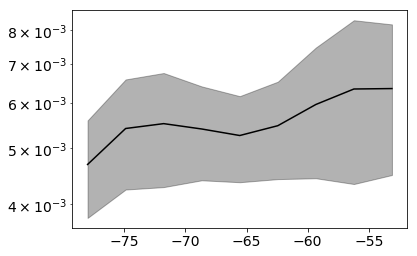

In [103]:
plt.plot(MUV[:-1], m_fr, 'k-')
plt.fill_between(MUV[:-1], m_fr-s_fr, m_fr+s_fr, color='k', alpha=.3)
plt.gca().set_yscale('log')                                                                                  

In [102]:
args.Npoints = 10
args.Ncount_min = 200
m_fr, s_fr= [np.zeros(args.Npoints-1) for i in range(2)]
for j in range(args.Npoints-1):
    # cond = (ANALYZED_DATA['COUNTER'][:,j]>args.Ncount_min) & (ANALYZED_DATA['MUA'][:,j]>0)
    cond = (ANALYZED_DATA['MUA'][:,j]>0)
    if len(ANALYZED_DATA['COUNTER'][:,j][cond])>0:
        weight_array = ANALYZED_DATA['COUNTER'][:,j][cond]/\
                                np.mean(ANALYZED_DATA['COUNTER'][:,j][cond])
        m_fr[j] = np.mean(ANALYZED_DATA['MUA'][:,j][cond]*weight_array)
        s_fr[j]=np.sqrt(np.mean((ANALYZED_DATA['MUA'][:,j][cond]-m_fr[j])**2\
                                *weight_array))
   

In [84]:
m_fr

array([ 0.00490548,  0.00547428,  0.00552371,  0.00538253,  0.00525238,
        0.00547427,  0.0059339 ,  0.00628541,  0.00638759])

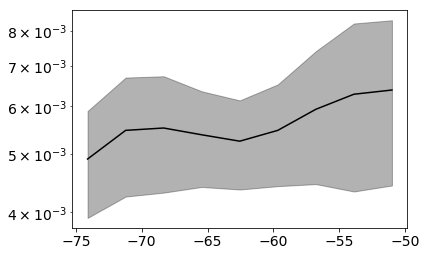

In [89]:
plt.plot(MUV[1:][m_fr>0], m_fr[m_fr>0], 'k-')
plt.fill_between(MUV[1:][m_fr>0], m_fr-s_fr, m_fr+s_fr, color='k', alpha=.3)
plt.gca().set_yscale('log')                                         

In [55]:
weight_array

array([ 0.,  0.,  0.,  0.,  2.,  2.,  2.,  2.,  2.,  0.])

/Users/yzerlaut/anaconda/lib/python3.5/site-packages/matplotlib/scale.py:111: RuntimeWarning: invalid value encountered in less_equal
  out[a <= 0] = -1000


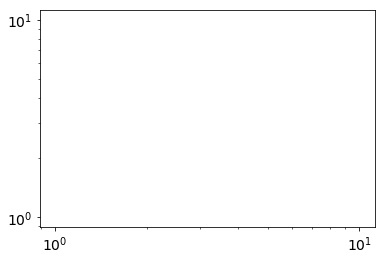

In [56]:
plt.loglog(MUV[1:], m_fr)

array([8, 9, 9, ..., 9, 9, 9])

In [ ]:

for n in np.concatenate([range(1), range(2,len(ANALYZED_DATA['muV']))]):
    cc, pf, muV = ANALYZED_DATA['CC_Vm_LFP'][n],\
                   ANALYZED_DATA['smooth_power_low_freq'][n],\
                    ANALYZED_DATA['muV'][n]
    for i, cond in zip(range(5),
                       [(pf>freq_threshold_high) & np.isfinite(cc),\
                        (pf>freq_threshold) & np.isfinite(cc),\
                        (pf<freq_threshold) & np.isfinite(cc) & (muV>bounds[0]) & (muV<=bounds[1]),
                        (pf<freq_threshold) & np.isfinite(cc) & (muV>bounds[1]) & (muV<=bounds[2]),
                        (pf<freq_threshold) & np.isfinite(cc) & (muV>bounds[2]) & (muV<=bounds[3])]):
        if len(cc[cond])>Ncount_min:
            # ax.plot([i-.15], [np.mean(cc[cond])], 'o',
            #         color=viridis(n/len(ANALYZED_DATA['muV'])))
            CC[i]['cc'].append(np.mean(cc[cond]))
            CC[i]['id'].append(n)
        ax2.semilogy([i+n*.03], [1+len(cc[cond])], 'o', color=viridis(n/len(ANALYZED_DATA['muV'])))


ValueError: setting an array element with a sequence.

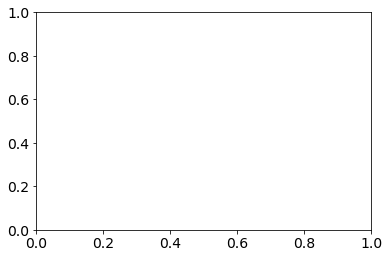

ValueError: setting an array element with a sequence.

In [30]:
plt.plot(ANALYZED_DATA['muV'], ANALYZED_DATA['MUA_Pow'], 'o')

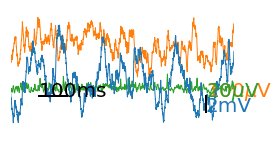

In [96]:
fig, _ = show_vm_and_lfp_and_MUA(t, Vm, LFP, MUA, 174.8, .8, 
                                 spikes=-45, LFP_loc=-73, MUA_loc=-73,
                                 figsize=(4,3),
                                 T_bar=0.1, LFP_bar=.1, Vm_bar=2, MUA_bar=0.02)

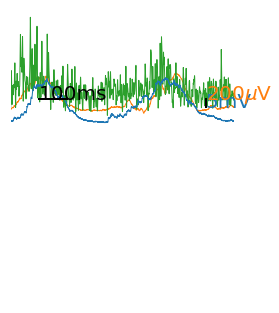

In [103]:
fig, _ = show_vm_and_lfp_and_MUA(t, Vm, LFP, MUA, 154.6, .8,
                      spikes=-45, LFP_loc=-80, MUA_loc=-100,
                      figsize=(4,3), T_bar=0.1, LFP_bar=0.2, Vm_bar=5, MUA_bar=0.001)


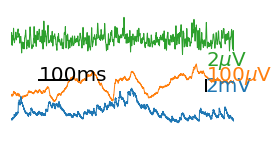

In [104]:


fig, ax = show_vm_and_lfp_and_MUA(t, Vm, LFP, MUA, 164.5, .8,
                      spikes=-45, LFP_loc=-86, MUA_loc=-83,
                      figsize=(4,3), T_bar=0.1, LFP_bar=.1, Vm_bar=2, MUA_bar=0.002)
